# Assignment 4

In this assignment, we will reimplement the POS tagger of Assignment 2 with neural networks.

We will use an LSTM sequence tagger and the Pytorch library.
There are a lot of tutorials on implementing neural tagging models on the Internet. You are welcome to read and watch them, but please submit code that is your own and not copied; plagiarism is not okay and will have consequences. Make sure you understand all the code you submit. I trust your honesty in this.


Be aware that training a neural network is time-intensive. On my computer, one epoch of training takes a few minutes, and a complete training run takes up to an hour. Consider developing and debugging your code on a subset of the training corpus until you believe it works correctly. Also, make sure you start early. If your own computer is not fast enough to train a neural network, feel free to use the department’s compute servers or Google Colab.

## Loading the training and test corpus

In a first step, you will load the training, development, and test data into a Pytorch [DataLoader](https://pytorch.org/docs/stable/data.html). We will use the German Universal Dependencies treebank as our dataset. It is annotated with POS tags, and indeed it is the same dataset that you used in Assignment 2, just in a different file format. Download the treebank from [Github](https://github.com/UniversalDependencies/UD_German-GSD); you need the files ```de_gsd-ud-{train|dev|test}.conllu```.

In [6]:
%%capture
! pip install wget
# we will use 'conllu' module for data processing later
! pip install conllu
# comet_ml is a library for advanced logging during training process (like Tensorboard)
! pip install comet_ml

In [7]:
import os

from typing import List, Union, Tuple

import wget
from comet_ml import Experiment

import torch
import torch.nn as nn
from torch.utils.data import DataLoader

In [8]:
# Download data files from github
file_source_to_localname = (
    r'https://raw.githubusercontent.com/UniversalDependencies/UD_German-GSD/master/de_gsd-ud-{}.conllu',
    '{}.conllu',
)

for data_split in ['test', 'dev', 'train']:
    localname = file_source_to_localname[1].format(data_split)
    if not os.path.isfile(localname):
        source_url = file_source_to_localname[0].format(data_split)
        wget.download(source_url, localname)

You will then have to load the corpus and convert it into a format that Pytorch can process. Data loading is a bit annoying and not very well documented, so I have implemented it for you. Download the file [data.py](https://drive.google.com/file/d/12j5vZ9Ssu5c14bqE0KajS66G8pc8TKoS/view) and ```import data``` in your program. I have uploaded this file to github to unify dowloading process and make the end-to-end notebook.

In [9]:
# I am loading data.py from my own github to unify loading process
if not os.path.isfile('data.py'):
    wget.download(
        'https://raw.githubusercontent.com/tsimafeip/LCT-master-course/main/Computational_Linguistics/HW4_NN_pos_tagger/data.py',
        'data.py',
    )

The function ```data.load(training_filename, dev_filename, test_filename)``` will return a tuple of the following values, in this order:

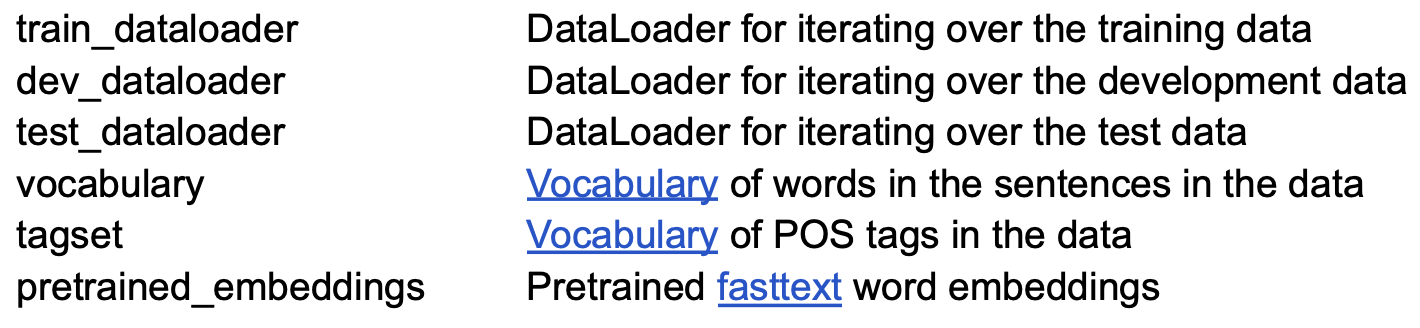

Note that the first time you call ```data.load```, it will download several gigabytes of pretrained word embeddings, which can take a while. The file then remains on your hard drive, so subsequent calls to ```data.load``` will be faster.

In [10]:
import data

#data.load(training_filename, dev_filename, test_filename)
train_dataloader, dev_dataloader, test_dataloader, vocab, tagset, fasttext_embeddings = data.load('train.conllu', 'dev.conllu', 'test.conllu')

.vector_cache/wiki.de.vec: 5.97GB [04:01, 24.8MB/s]                            
100%|██████████| 2275233/2275233 [04:44<00:00, 8008.10it/s]


Each [dataloader](https://pytorch.org/docs/stable/data.html) is an iterable over minibatches of (training, dev, or test) data. In our case, each minibatch contains a single instance (i.e., the batch size is 1); if batch is an element of the iterable, then batch[0] is of the form (sentence, gold_tags), where sentence and gold_tags are both LongTensors of shape (sequence length,). The numbers in sentence are indices in the vocabulary; the numbers in gold_tags are indices in the tagset.

Have a look at the first instance in the train_dataloader and print out the original sentence and POS tags (in human-readable form, not the numbers).

In [11]:
# some exploratory data analysis
print(len(train_dataloader), len(dev_dataloader), len(test_dataloader))
print(type(tagset), type(vocab), type(pretrained_embeddings))
print(tagset.lookup_token(10), vocab.lookup_token(10))
print(pretrained_embeddings.shape)

13814 799 977
<class 'torchtext.vocab.vocab.Vocab'> <class 'torchtext.vocab.vocab.Vocab'> <class 'torch.Tensor'>
CCONJ von
torch.Size([50506, 300])


In [12]:
for item in train_dataloader:
    # I convert to numpy because lookup tokens does not accept torch tensors
    tokens, tags = item[0][0].numpy(), item[0][1].numpy()
    
    print(vocab.lookup_tokens(tokens))
    print(tagset.lookup_tokens(tags))
    break

['sehr', 'gute', 'beratung', ',', 'schnelle', 'behebung', 'der', 'probleme', ',', 'so', 'stelle', 'ich', 'mir', 'kundenservice', 'vor', '</s>']
['ADV', 'ADJ', 'NOUN', 'PUNCT', 'ADJ', 'NOUN', 'DET', 'NOUN', 'PUNCT', 'ADV', 'VERB', 'PRON', 'PRON', 'NOUN', 'ADP', 'PUNCT']


## Defining a neural model

Implement an LSTM-based POS tagger in Pytorch. In a first step, your tagger should assign pretrained word embeddings to the tokens in the sentence, using an [Embedding](https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html) layer. If your Embedding layer has the right size (the fasttext word embeddings have dimension 300), you can inject the pretrained embeddings into it as follows:

```
embedding.weight.data = pretrained_embeddings
embedding.weight.requires_grad = False
```


Your neural model should then pass these word embeddings as input to an [LSTM](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html) layer and project the LSTM’s hidden states into the dimension of the output vocabulary with a [Linear](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html) layer of appropriate size. The result of applying your model to a sentence tensor of shape ```(sequence length,)``` should be a tensor of POS scores of shape ```(sequence length, tagset size)```. Note that because there is only one sequence in each batch, you do not have to worry about padding the sequences in a batch to the same length, as some tutorials might suggest.

In [45]:
hyperparams = {
    "input_size": len(vocab),
    "hidden_size": 128,
    "num_classes": len(tagset),
    "embeddings_type": 'fasttext',
    "batch_size": 1,
    "num_epochs": 10,
    "learning_rate": 0.001,
    "num_lstm_layers": 2,
    "bidirectional": True,
    "dropout": 0.25,
}

MY_API_KEY = None
COMET_PROJECT_NAME = None
COMET_WORKSPACE = None

# Here comet-experiment is created
# Populate personal api key if you want it actually to run
experiment = Experiment(
    api_key=MY_API_KEY,
    project_name=COMET_PROJECT_NAME,
    workspace=COMET_WORKSPACE,
)
experiment.log_parameters(hyperparams)

ValueError: ignored

In [36]:
class NeuralPosTagger(nn.Module):
    """
    """

    def __init__(self,
                input_size: int,
                hidden_size: int,
                output_size: int,
                pretrained_embeddings: torch.Tensor,
                lstm_layers_num: int = 1,
                bidirectional: bool = False,
                dropout: float = 0):
        """
        """
        # Initializes internal Module state.
        super(NeuralPosTagger, self).__init__()

        # embedding layers tranforms binary vector to smaller reprensenation with non-binary elements
        self.embedding = nn.Embedding.from_pretrained(pretrained_embeddings, freeze=True)

        # here we create LSTM layer that mostly defines the architecture of the whole RNN
        self.lstm = nn.LSTM(self.embedding.embedding_dim, hidden_size, 
                            batch_first=True,
                            num_layers = lstm_layers_num, 
                            bidirectional = bidirectional)
        
        # final layer is used for transforming vector of hidden_size to the vector of the required output length
        self.final_linear = nn.Linear(hidden_size * 2 if bidirectional else hidden_size, output_size)

        # dropout layer to regulize training and avoid overfitting
        self.dropout = nn.Dropout(dropout)


    ## forward function
    def forward(self, raw_input: torch.Tensor):
        """
        Forward path of the model.

        raw_input: torch.Tensor - tensor of shape (sequence_len,)
        """

        sequence_length = raw_input.size(0)

        # transform raw input to dense embedding vector of shape (sequence_len, embedding_size)
        # and add dummy batch_size 1 as a first dimension 
        # resulting tensor has shape (1, sequence_len, embedding_size)
        embedded_input = self.embedding(raw_input).view(1, sequence_length, -1)

        # lstm_output has two possible shapes:
        # (1, sequence_len, hidden_size) for unidirectional LSTM model
        # (1, sequence_len, 2*hidden_size) for bidirectional LSTM model
        lstm_output, _ = self.lstm(embedded_input)

        # predictions has shape (1, sequence_len, num_classes)
        predictions = self.final_linear(self.dropout(lstm_output))

        # reshaping to remove artificial batch dimension
        return predictions.view(sequence_length, -1)

model = NeuralPosTagger(input_size=hyperparams['input_size'],
                        hidden_size=hyperparams['hidden_size'],
                        output_size=hyperparams['num_classes'],
                        pretrained_embeddings=fasttext_embeddings,
                        lstm_layers_num=hyperparams["num_lstm_layers"],
                        bidirectional=hyperparams["bidirectional"],
                        dropout=hyperparams["dropout"])

# check if forward path works
for item in train_dataloader:
    tokens = item[0][0]
    model.forward(tokens)
    break

Use a [cross-entropy](https://pytorch.org/docs/stable/generated/torch.nn.functional.cross_entropy.html#torch.nn.functional.cross_entropy) loss to compare the predictions of your model against the gold_tags, and use the [Adam](https://pytorch.org/docs/stable/optim.html) optimizer to train your model. Print the mean training loss per epoch after each epoch to check that your model is actually learning something. The mean loss should be below 0.2. Note that the cross-entropy loss wants the raw scores (“logits”) as input, before computing the softmax or log-softmax; this is why we did not implement a softmax layer after the Linear layer above.

In [37]:
OPTIMIZER_CLASS = torch.optim.Adam
LOSS_FUNCTION = nn.functional.cross_entropy

Ingridients:

1. Model
2. Optimizer
3. Loss function
4. Data loader for train

Steps:

0. Turn model to training mode
1. Iterate by epochs
2. Feed input data to model, get output.
3. Calculate loss using loss function
4. Optimizer.zero_grad()
5. Loss.backward()
6. Optimizer.step()

In [38]:
def get_num_of_correct_tags(gold_tags: torch.Tensor, prediction_output: torch.Tensor) -> int:
    """Returns correct tags and total tags based on gold tags and prediction output."""
    # chooses tag with max probability value as predicted tag for input token
    # torch.max returns (value, indices) tuple, we do not need values here.
    _, predicted_tags = torch.max(prediction_output.data, 1)
    # correct tags is a single scalar tensor, then we call item() to get the underlying value
    correct_tags = (predicted_tags == gold_tags.data).sum().item()

    return correct_tags


def accuracy(gold_tags: torch.Tensor, prediction_output: torch.Tensor) -> float:
    """Calculates accuracy based on gold tags and prediction output for the single sentence."""
    # chooses tag with max probability value as predicted tag for input token
    _, predicted_tags = torch.max(prediction_output.data, 1)
    total_tags = gold_tags.size(0)
    # correct tags is a single scalar tensor, then we call item() to get the underlying value
    correct_tags = (predicted_tags == gold_tags.data).sum().item()

    return correct_tags / total_tags

In [39]:
def train_loop(model: nn.Module, optimizer: torch.optim.Optimizer, loss_function, dataloader: DataLoader) -> Tuple[float, float]:
    """
    Runs one complete training epoch, i. e. trains the model on the whole amount of available training data and updates weights.
    :param model: a pytorch model
    :param optimizer: a pytorch optimizer
    :param loss_function: the type of loss function to use
    :param dataloader: a dataloader for getting the training instances

    :return: (epoch_loss, epoch_accuracy): metrics to evaluate the current state of model
    """
    correct_tags = total_tags = loss_sum = epoch_loss = epoch_accuracy = 0
    # turns model to train mode: activates dropout and some other features that are useful only for training.
    model.train()
    # this context manager only appends 'train' prefixes to all logged metrics
    with experiment.train():
        for i, item in enumerate(dataloader):
            # simple logging to understand the stage of training process inside one epoch
            if (i + 1) % 1000 == 0:
                print(i + 1, end=" ")

            # two 1d-vector-like Tensors with the same length
            input_tokens, gold_tags = item[0][0], item[0][1]

            # matrix with vector of tag probabilities as rows for each token
            prediction_output = model.forward(input_tokens)
            loss = loss_function(prediction_output, gold_tags)

            # backpropagation
            # make gradients zero
            optimizer.zero_grad()
            # calculate backward pass
            loss.backward()
            # make optimizer step
            optimizer.step()

            # update loss and accuracy
            loss_sum += loss.item()
            correct_tags += get_num_of_correct_tags(gold_tags, prediction_output)
            total_tags += gold_tags.size(0)
        
        epoch_accuracy = correct_tags / total_tags
        epoch_loss = loss_sum / len(dataloader)
        # Log epoch accuracy to Comet.ml
        experiment.log_metric("avg_epoch_accuracy", epoch_accuracy, epoch=epoch)
        experiment.log_metric("avg_epoch_loss", epoch_loss, epoch=epoch)

        return epoch_loss, epoch_accuracy


def validation_loop(model: nn.Module, loss_function, dataloader: DataLoader) -> Tuple[float, float]:
    """
    Runs one complete validation (test) loop, 
    i. e. validates(tests) the model on the whole amount of available validation (test) data and reports quality metrics.

    :param model: a pytorch model
    :param loss_function: the type of loss function to use
    :param dataloader: a dataloader for getting the validation (test) instances

    :return: (epoch_loss, epoch_accuracy): metrics to evaluate the current state of model
    """
    correct_tags = total_tags = loss_sum = epoch_loss = epoch_accuracy = 0
    model.eval()
    with experiment.validate():
        # we freeze gradient calculation for validation and, therefore, do not update weights
        # in other steps it is the same process as for training
        with torch.no_grad():
            for i, item in enumerate(dataloader):
                input_tokens, gold_tags = item[0][0], item[0][1]
                predicted_tags = model.forward(input_tokens)
                
                loss_sum += loss_function(predicted_tags, gold_tags).item()
                correct_tags += get_num_of_correct_tags(gold_tags, predicted_tags)
                total_tags += gold_tags.size(0)
        
        epoch_accuracy = correct_tags / total_tags
        epoch_loss = loss_sum / len(dataloader)
        # Log epoch accuracy to Comet.ml
        experiment.log_metric("avg_epoch_accuracy", epoch_accuracy, epoch=epoch)
        experiment.log_metric("avg_epoch_loss", epoch_loss, epoch=epoch)

    return epoch_loss, epoch_accuracy

In [40]:
best_epoch = best_accuracy = best_val_loss = float('inf')

# create optimizer instance
optimizer = OPTIMIZER_CLASS(model.parameters(), lr=hyperparams["learning_rate"])
# iterates by epochs
for epoch in range(1, hyperparams['num_epochs'] + 1):
    print(f'Epoch #{epoch}')
    train_loss, train_accuracy = train_loop(model, optimizer, LOSS_FUNCTION, train_dataloader)
    val_loss, val_accuracy = validation_loop(model, LOSS_FUNCTION, dev_dataloader)

    print()
    print(f"Train: Loss {train_loss} | Accuracy {train_accuracy}")
    print(f"Validation: Loss {val_loss} | Accuracy {val_accuracy}")

    # saving best checkpoint
    if val_loss < best_val_loss:
        print(f'SAVING BEST MODEL WITH VAL_LOSS={val_loss}.')
        best_val_loss = val_loss
        best_epoch = epoch
        best_accuracy = val_accuracy
        torch.save(model.state_dict(), 'best-model.pt')

Epoch #1
1000 2000 3000 4000 5000 6000 7000 8000 9000 10000 11000 12000 13000 
Train: Loss 0.24683511772832348 | Accuracy 0.9250560701006654
Validation: Loss 0.28469915426387515 | Accuracy 0.9200790513833992
SAVING BEST MODEL WITH VAL_LOSS=0.28469915426387515.
Epoch #2
1000 2000 3000 4000 5000 6000 7000 8000 9000 10000 11000 12000 13000 
Train: Loss 0.12967855896545172 | Accuracy 0.9559560976700172
Validation: Loss 0.270450675214445 | Accuracy 0.9251383399209486
SAVING BEST MODEL WITH VAL_LOSS=0.270450675214445.
Epoch #3
1000 2000 3000 4000 5000 6000 7000 8000 9000 10000 11000 12000 13000 
Train: Loss 0.08986914763786207 | Accuracy 0.9675985604327643
Validation: Loss 0.2716383650827886 | Accuracy 0.9295652173913044
Epoch #4
1000 2000 3000 4000 5000 6000 7000 8000 9000 10000 11000 12000 13000 
Train: Loss 0.06312507087250822 | Accuracy 0.9761338827333894
Validation: Loss 0.3087563549572761 | Accuracy 0.9275889328063242
Epoch #5
1000 2000 3000 4000 5000 6000 7000 8000 9000 10000 11000 12

## Plotting learning curves

When developing neural networks, it is crucial to visualize the dynamics of the learning process. This will give you valuable information about whether your [hyperparameters](https://machinelearningmastery.com/understand-the-dynamics-of-learning-rate-on-deep-learning-neural-networks/) are right, whether there are bugs in your code, whether you are [overfitting or underfitting](https://machinelearningmastery.com/learning-curves-for-diagnosing-machine-learning-model-performance/), and whether you have trained your model for enough epochs.

Create a free account on [comet.ml](https://www.comet.ml/) and [follow the instructions](https://www.comet.ml/docs/quick-start/) to log data about your training run. You should at least log the training loss after each epoch. Submit a screenshot of a training run.

![Training Loss](https://github.com/tsimafeip/LCT-master-course/blob/main/Computational_Linguistics/HW4_NN_pos_tagger/graphs/train_loss.jpg?raw=1)

![Training Loss Per Epoch](https://github.com/tsimafeip/LCT-master-course/blob/main/Computational_Linguistics/HW4_NN_pos_tagger/graphs/train_epoch_loss.jpg?raw=1)

![Training Accuracy Per Epoch](https://github.com/tsimafeip/LCT-master-course/blob/main/Computational_Linguistics/HW4_NN_pos_tagger/graphs/train_accuracy.jpg?raw=1)

![Validation Loss Per Epoch](https://github.com/tsimafeip/LCT-master-course/blob/main/Computational_Linguistics/HW4_NN_pos_tagger/graphs/validation_loss.jpg?raw=1)

![Validation Accuracy Per Epoch](https://github.com/tsimafeip/LCT-master-course/blob/main/Computational_Linguistics/HW4_NN_pos_tagger/graphs/validation_accuracy.jpg?raw=1)

## Evaluation

Write a function that evaluates the tagging accuracy of your model on a given sentence. Evaluate the accuracy of your model on the training and development corpus after each epoch, and have them plotted on comet.ml.

The training accuracy is of course an overly optimistic picture of the actual quality of your system’s predictions. However, it is useful to judge whether your model is sufficiently powerful. Your aim should be to get a training accuracy that’s close to 100%; if it is not, then you either have a bug in your code, or your model is too simple.

Once you have satisfied yourself that your system works well on the development data, evaluate it on the test data and report the tagging accuracy. Please resist the temptation to evaluate your tagger on the test data frequently; this will make your results less meaningful. It is okay to evaluate on the development data as often as you like, that’s what it is there for.

You can either evaluate your trained model immediately after a training run, within the same Python file, or you can [save your model to a file](https://pytorch.org/tutorials/beginner/saving_loading_models.html) after training and then load it and do the evaluation in a separate program.

In [41]:
model.load_state_dict(torch.load('best-model.pt'))

test_loss, test_acc = validation_loop(model, LOSS_FUNCTION, test_dataloader)

print(f"Test: Loss {test_loss} | Accuracy {test_acc}")

Test: Loss 0.28928014370390576 | Accuracy 0.9268423563081326


In [42]:
# submits all data to Comet ML
experiment.end()

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/tsimafeip/general/0bb2681dfa9c48fc9c64e64008bbba4d
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     train_avg_epoch_accuracy [10]    : (0.9250560701006654, 0.9889051986856126)
COMET INFO:     train_avg_epoch_loss [10]        : (0.026170864921481178, 0.24683511772832348)
COMET INFO:     train_loss [13814]               : (1.32454729850906e-07, 2.910433053970337)
COMET INFO:     validate_avg_epoch_accuracy [11] : (0.9200790513833992, 0.9304347826086956)
COMET INFO:     validate_avg_epoch_loss [11]     : (0.270450675214445, 0.45427448443476914)
COMET INFO:   Others:
COMET INFO:     notebook_url : https://colab.research.google.com/notebook#fileId=https%3A%2F%2Fgithub.com%2Ftsimafeip%2FLCT-master-course%2Fblob%2Fmain%2FComputational_Linguistic

In [43]:
def predict_pos(sentence: Union[List[str], str]) -> List[str]:
    """
    Predicts parts of speech for input German sentence.

    :param sentence: sentence as sequence of tokens or as single string.

    :return: tags: predictes part-of-speech tags
    """
    if isinstance(sentence, str):
        sentence = sentence.split()

    sentence_numerical_vector = torch.LongTensor(vocab.lookup_indices(sentence))

    outputs = model.forward(sentence_numerical_vector)
    _, predicted_tags_indices = torch.max(outputs.data, 1)

    predicted_tags = tagset.lookup_tokens(predicted_tags_indices.numpy())
    
    print(sentence)
    print(predicted_tags)

    return predicted_tags

# demo for inference
for test_item in test_dataloader:
    tokens, tags = test_item[0][0].numpy(), test_item[0][1].numpy()

    predict_pos(vocab.lookup_tokens(tokens))
    break

['der', 'hauptgang', 'war', 'in', 'ordnung', ',', 'aber', 'alles', 'andere', 'als', 'umwerfend', '</s>']
['DET', 'NOUN', 'AUX', 'ADP', 'NOUN', 'PUNCT', 'CCONJ', 'PRON', 'PRON', 'ADP', 'ADJ', 'PUNCT']


## Hyperparameters

Your model has a lot of hyperparameters that you can experiment with. Play with different values and determine which one gives you the best results on the development set. There is no need to report results on this section of the assignment, but of course the thoroughness of your hyperparameter optimization will affect the final accuracy of your model.

Here are some hyperparameters you can manipulate:
- learning rate of the Adam optimizer
- dimensionality of the hidden states of the LSTM
- number of layers of the LSTM
- ordinary or bidirectional LSTM?
- if your LSTM has at least two layers, what dropout do you use?

1) I have started with simple unidirectional one-layer LSTM. It was not learning sufficiently.

2) I added 2d LSTM layer, 0.25 dropout and biderectionality. 0.01 learning rate worked badly, then I changed it to 0.001.